# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [2]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [3]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [4]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [5]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균
vars_target = ['Income', 'Total_Spending', 'Age']

for col in vars_target:
    data = df[col]

    mean_val = data.mean()
    median_val = data.median()
    mode_val = data.mode().iloc[0]          # 최빈값 여러 개일 수 있으니 첫 번째
    trim_mean_val = trim_mean(data, 0.05)   # 이미 import 되어 있음

    print(f"\n[{col}]")
    print(f"평균(mean): {mean_val:,.2f}")
    print(f"중앙값(median): {median_val:,.2f}")
    print(f"최빈값(mode): {mode_val:,.2f}")
    print(f"5% 절사평균(trimmed mean): {trim_mean_val:,.2f}")


[Income]
평균(mean): 51,952.61
중앙값(median): 51,381.50
최빈값(mode): 51,381.50
5% 절사평균(trimmed mean): 51,740.15

[Total_Spending]
평균(mean): 605.99
중앙값(median): 396.50
최빈값(mode): 46.00
5% 절사평균(trimmed mean): 561.12

[Age]
평균(mean): 55.10
중앙값(median): 54.00
최빈값(mode): 48.00
5% 절사평균(trimmed mean): 55.07


In [6]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)
for col in vars_target:
    data = df[col]

    var_val = data.var(ddof=1)          # 표본분산
    std_val = data.std(ddof=1)          # 표본표준편차

    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr_val = q3 - q1                   # 사분위범위

    cv_val = (std_val / data.mean()) * 100  # 변동계수(%)

    print(f"\n[{col}]")
    print(f"분산(variance): {var_val:,.2f}")
    print(f"표준편차(std): {std_val:,.2f}")
    print(f"IQR: {iqr_val:,.2f}")
    print(f"변동계수(CV): {cv_val:.2f}%")


[Income]
분산(variance): 458,450,912.69
표준편차(std): 21,411.47
IQR: 32,773.25
변동계수(CV): 41.21%

[Total_Spending]
분산(variance): 362,241.67
표준편차(std): 601.87
IQR: 976.50
변동계수(CV): 99.32%

[Age]
분산(variance): 136.97
표준편차(std): 11.70
IQR: 18.00
변동계수(CV): 21.24%


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

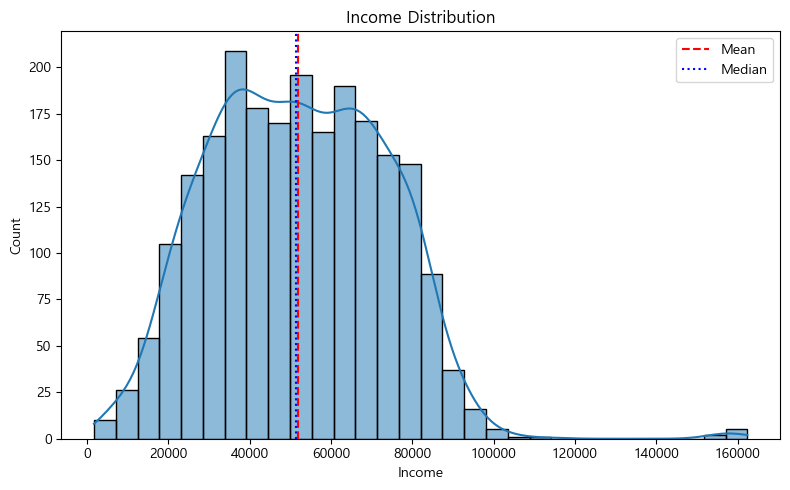

In [7]:
# TODO 1-2(a): Income 히스토그램 + KDE
plt.figure(figsize=(8, 5))

sns.histplot(df['Income'], bins=30, kde=True)

mean_income = df['Income'].mean()
median_income = df['Income'].median()

plt.axvline(mean_income, color='red', linestyle='--', label='Mean')
plt.axvline(median_income, color='blue', linestyle=':', label='Median')

plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

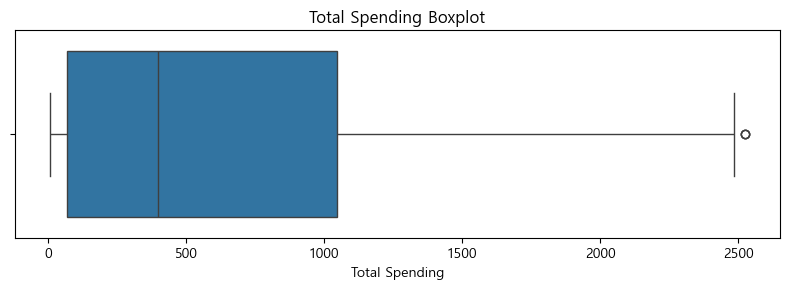

Total_Spending 이상치 개수 (IQR 기준): 3


In [8]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치
plt.figure(figsize=(8, 3))

sns.boxplot(x=df['Total_Spending'], orient='h')

plt.title('Total Spending Boxplot')
plt.xlabel('Total Spending')
plt.tight_layout()
plt.show()

Q1 = df['Total_Spending'].quantile(0.25)
Q3 = df['Total_Spending'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[
    (df['Total_Spending'] < lower_bound) |
    (df['Total_Spending'] > upper_bound)
]

print(f"Total_Spending 이상치 개수 (IQR 기준): {len(outliers)}")

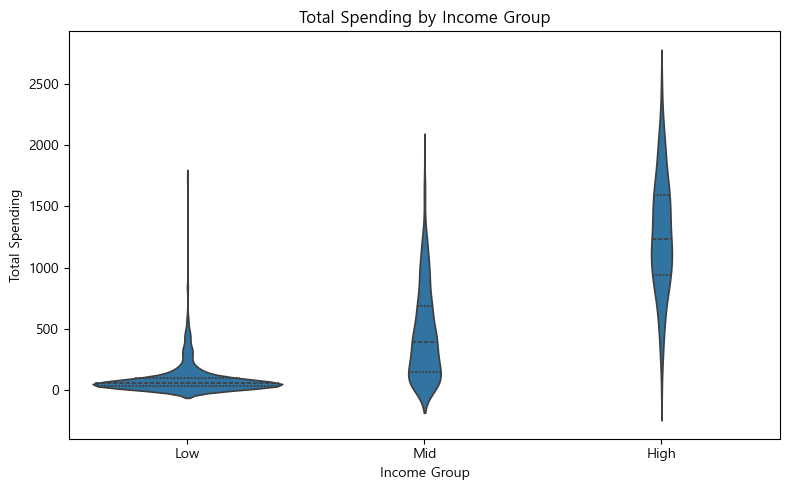

In [9]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯
plt.figure(figsize=(8, 5))

sns.violinplot(
    x='Income_Group',
    y='Total_Spending',
    data=df,
    inner='quartile'
)

plt.title('Total Spending by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Total Spending')
plt.tight_layout()
plt.show()

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [10]:
spending_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력
spending_cols = [
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]

for col, name in zip(spending_cols, spending_names):
    data = df[col]

    skew_val = stats.skew(data)
    kurt_val = stats.kurtosis(data)   # 초과 첨도 (Fisher)

    print(f"{name:>7} | 왜도: {skew_val:6.2f} | 첨도: {kurt_val:6.2f}")

  Wines | 왜도:   1.18 | 첨도:   0.60
 Fruits | 왜도:   2.10 | 첨도:   4.06
   Meat | 왜도:   2.08 | 첨도:   5.52
   Fish | 왜도:   1.92 | 첨도:   3.09
 Sweets | 왜도:   2.13 | 첨도:   4.36
   Gold | 왜도:   1.88 | 첨도:   3.55


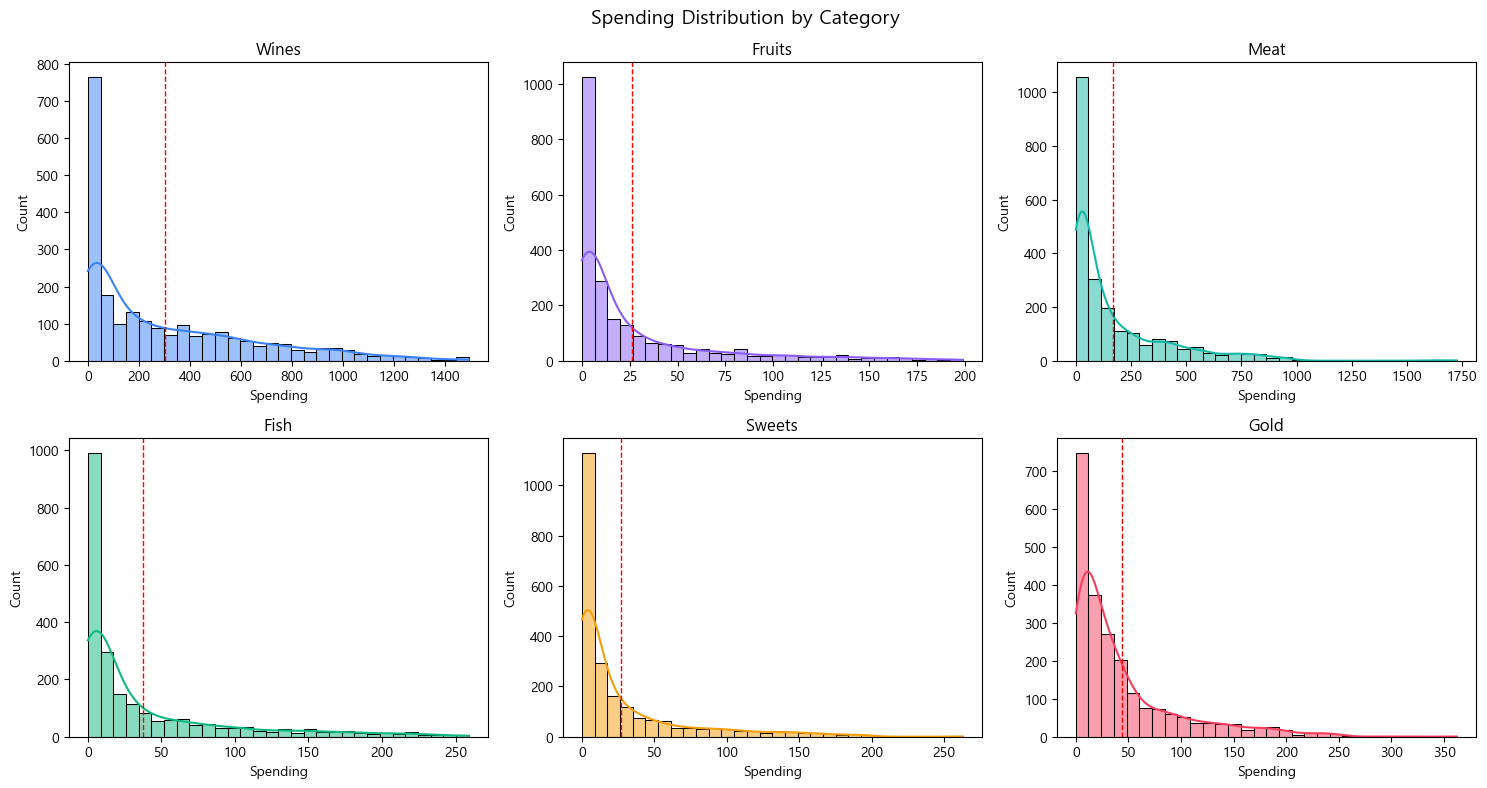

In [11]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (col, name) in enumerate(zip(spending_cols, spending_names)):
    ax = axes[i]
    data = df[col]

    sns.histplot(
        data,
        bins=30,
        kde=True,
        color=hist_colors[i],
        ax=ax
    )

    mean_val = data.mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1)

    ax.set_title(name)
    ax.set_xlabel('Spending')
    ax.set_ylabel('Count')

plt.suptitle('Spending Distribution by Category', fontsize=14)
plt.tight_layout()
plt.show()

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [13]:
# TODO 1-4: 비즈니스 인사이트 정리
print("1. 고객 특성 요약")
print("- 40~50대가 핵심 고객층")
print("- 소수의 고소득 고객이 평균을 끌어올리는 구조")
print("- 소비 분포는 강한 양의 왜도와 높은 첨도를 보임")

print("\n2. 핵심 발견 사항")
print("- 중앙값, IQR, 절사평균을 병행한 해석이 적절")
print("- 소득 수준이 높아질수록 소비 중앙값과 분산이 모두 증가")
print("- 소득 수준은 소비 규모뿐 아니라 소비 변동성에도 영향을 미침")

print("\n3. 후속 분석에서 검증할 가설")

print("3-1. 소득 수준에 따른 캠페인 반응 차이")
print("  H₀: Income_Group에 따른 캠페인 수락률(Response)은 차이가 없다")
print("  H₁: 고소득 그룹일수록 캠페인 수락률이 높다")

print("\n3-2. 소비 규모와 캠페인 반응의 관계")
print("  H₀: Total_Spending과 캠페인 수락 여부는 독립이다")
print("  H₁: Total_Spending이 높을수록 캠페인 수락 확률이 증가한다")

print("\n3-3. 자녀 유무에 따른 소비/반응 차이")
print("  H₀: Has_Children 여부에 따라 소비 수준 및 캠페인 반응은 차이가 없다")
print("  H₁: 자녀가 없는 고객이 특정 상품군(와인 등)에서 더 높은 소비/반응을 보인다")

1. 고객 특성 요약
- 40~50대가 핵심 고객층
- 소수의 고소득 고객이 평균을 끌어올리는 구조
- 소비 분포는 강한 양의 왜도와 높은 첨도를 보임

2. 핵심 발견 사항
- 중앙값, IQR, 절사평균을 병행한 해석이 적절
- 소득 수준이 높아질수록 소비 중앙값과 분산이 모두 증가
- 소득 수준은 소비 규모뿐 아니라 소비 변동성에도 영향을 미침

3. 후속 분석에서 검증할 가설
3-1. 소득 수준에 따른 캠페인 반응 차이
  H₀: Income_Group에 따른 캠페인 수락률(Response)은 차이가 없다
  H₁: 고소득 그룹일수록 캠페인 수락률이 높다

3-2. 소비 규모와 캠페인 반응의 관계
  H₀: Total_Spending과 캠페인 수락 여부는 독립이다
  H₁: Total_Spending이 높을수록 캠페인 수락 확률이 증가한다

3-3. 자녀 유무에 따른 소비/반응 차이
  H₀: Has_Children 여부에 따라 소비 수준 및 캠페인 반응은 차이가 없다
  H₁: 자녀가 없는 고객이 특정 상품군(와인 등)에서 더 높은 소비/반응을 보인다


---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [14]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10

p = df['Response'].mean()   # 수락률
print(f"캠페인 수락률 p = {p:.4f}")

# (a) 정확히 2명 수락
prob_x2 = stats.binom.pmf(2, n_trial, p)
print(f"P(X = 2) = {prob_x2:.4f}")

# (b) 3명 이상 수락
prob_ge3 = 1 - stats.binom.cdf(2, n_trial, p)
print(f"P(X ≥ 3) = {prob_ge3:.4f}")

캠페인 수락률 p = 0.1494
P(X = 2) = 0.2752
P(X ≥ 3) = 0.1782


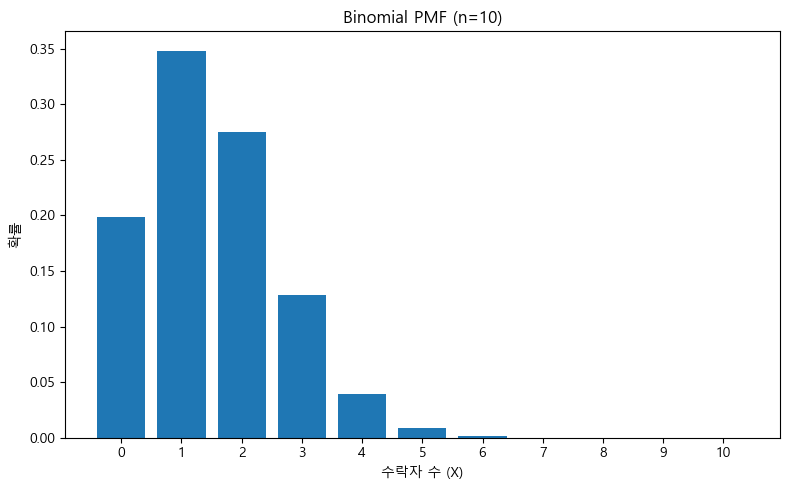

In [15]:
# TODO 2-1(c): 이항분포 PMF 시각화
x = np.arange(0, n_trial + 1)
pmf_vals = stats.binom.pmf(x, n_trial, p)

plt.figure(figsize=(8, 5))
plt.bar(x, pmf_vals)
plt.xlabel("수락자 수 (X)")
plt.ylabel("확률")
plt.title("Binomial PMF (n=10)")
plt.xticks(x)
plt.tight_layout()
plt.show()

In [16]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100

# 100명 발송 시 기대 수락자
expected_val = n_campaign * p
print(f"기대 수락자 수 E(X) = {expected_val:.2f}")

# P(X≥15)
prob_ge15 = 1 - stats.binom.cdf(14, n_campaign, p)
print(f"P(X ≥ 15) = {prob_ge15:.4f}")

# 90% 보장 최소 수락 수
for k in range(n_campaign + 1):
    if stats.binom.cdf(k, n_campaign, p) >= 0.90:
        k_min = k
        break

print(f"90% 보장 최소 수락 수 k = {k_min}")

기대 수락자 수 E(X) = 14.94
P(X ≥ 15) = 0.5358
90% 보장 최소 수락 수 k = 20


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [17]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
lambda_hat = web_visits.mean()
var_hat = web_visits.var(ddof=1)

print("[포아송 분포 적합 평가]")
print(f"표본 평균 (λ 추정값): {lambda_hat:.3f}")
print(f"표본 분산: {var_hat:.3f}")
print(f"평균 ≈ 분산 여부: {abs(lambda_hat - var_hat) < 1.0}")

[포아송 분포 적합 평가]
표본 평균 (λ 추정값): 5.319
표본 분산: 5.890
평균 ≈ 분산 여부: True


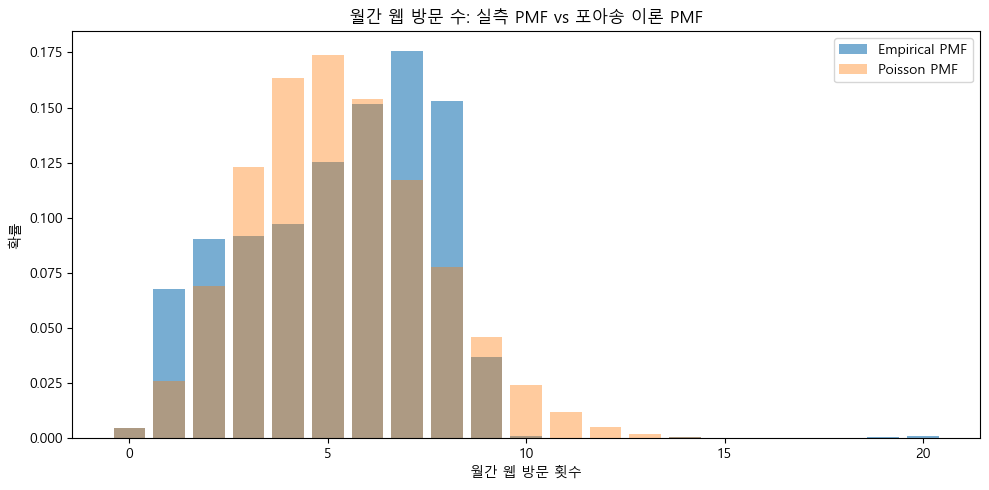

In [18]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
max_visit = web_visits.max()
x_vals = np.arange(0, max_visit + 1)

# 실측 PMF
empirical_pmf = web_visits.value_counts(normalize=True).sort_index()

# 이론 PMF
theoretical_pmf = stats.poisson.pmf(x_vals, lambda_hat)

plt.figure(figsize=(10, 5))

plt.bar(
    empirical_pmf.index,
    empirical_pmf.values,
    alpha=0.6,
    label='Empirical PMF'
)

plt.bar(
    x_vals,
    theoretical_pmf,
    alpha=0.4,
    label='Poisson PMF'
)

plt.xlabel("월간 웹 방문 횟수")
plt.ylabel("확률")
plt.title("월간 웹 방문 수: 실측 PMF vs 포아송 이론 PMF")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10

prob_heavy = 1 - stats.poisson.cdf(heavy_threshold - 1, lambda_hat)
print(f"P(X ≥ {heavy_threshold}) = {prob_heavy:.4f} ({prob_heavy*100:.2f}%)")

P(X ≥ 10) = 0.0449 (4.49%)


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [20]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교
income = df['Income']

# 모수 추정 (표본 기반)
mu_hat = income.mean()
sigma_hat = income.std(ddof=1)

print(f"추정 μ = {mu_hat:,.2f}, 추정 σ = {sigma_hat:,.2f}")

# CDF로 확률 계산
p_theory_lt_30000 = stats.norm.cdf(30000, loc=mu_hat, scale=sigma_hat)
p_theory_gt_80000 = 1 - stats.norm.cdf(80000, loc=mu_hat, scale=sigma_hat)

# 실측 비율
p_emp_lt_30000 = (income < 30000).mean()
p_emp_gt_80000 = (income > 80000).mean()

print("\n[이론 vs 실측 비교]")
print(f"P(Income < 30000) 이론: {p_theory_lt_30000:.4f} | 실측: {p_emp_lt_30000:.4f}")
print(f"P(Income > 80000) 이론: {p_theory_gt_80000:.4f} | 실측: {p_emp_gt_80000:.4f}")

# PPF로 상위 10% 기준 (즉 90퍼센타일)
top10_cut_theory = stats.norm.ppf(0.90, loc=mu_hat, scale=sigma_hat)
top10_cut_emp = income.quantile(0.90)

print("\n[상위 10% 소득 기준값]")
print(f"이론(정규 PPF, 90퍼센타일): {top10_cut_theory:,.0f}")
print(f"실측(표본 90퍼센타일): {top10_cut_emp:,.0f}")

추정 μ = 51,952.61, 추정 σ = 21,411.47

[이론 vs 실측 비교]
P(Income < 30000) 이론: 0.1526 | 실측: 0.1655
P(Income > 80000) 이론: 0.0951 | 실측: 0.0962

[상위 10% 소득 기준값]
이론(정규 PPF, 90퍼센타일): 79,393
실측(표본 90퍼센타일): 79,748


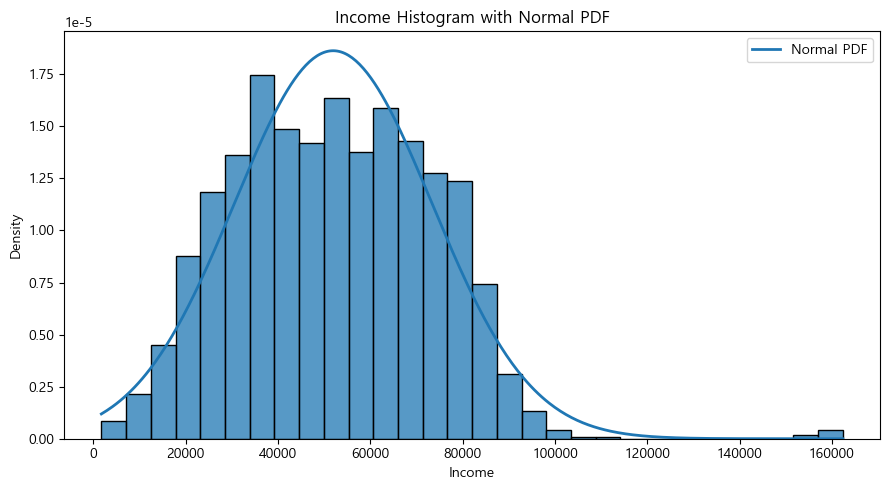

In [21]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기
plt.figure(figsize=(9, 5))

# 히스토그램(확률밀도 스케일)
sns.histplot(income, bins=30, stat='density', kde=False)

# 정규 PDF 곡선
x = np.linspace(income.min(), income.max(), 400)
pdf = stats.norm.pdf(x, loc=mu_hat, scale=sigma_hat)
plt.plot(x, pdf, linewidth=2, label='Normal PDF')

plt.title("Income Histogram with Normal PDF")
plt.xlabel("Income")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선
# VIP: 상위 5% → 95퍼센타일
vip_cut_theory = stats.norm.ppf(0.95, loc=mu_hat, scale=sigma_hat)
vip_cut_emp = income.quantile(0.95)

# 할인: 하위 10% → 10퍼센타일
discount_cut_theory = stats.norm.ppf(0.10, loc=mu_hat, scale=sigma_hat)
discount_cut_emp = income.quantile(0.10)

print("\n[실무 기준선]")
print(f"VIP 기준(상위 5%)  이론: {vip_cut_theory:,.0f} | 실측: {vip_cut_emp:,.0f}")
print(f"할인 기준(하위 10%) 이론: {discount_cut_theory:,.0f} | 실측: {discount_cut_emp:,.0f}")


[실무 기준선]
VIP 기준(상위 5%)  이론: 87,171 | 실측: 83,898
할인 기준(하위 10%) 이론: 24,513 | 실측: 24,214


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [23]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE
data = df['Total_Spending']
n = data.shape[0]
mean_val = data.mean()
std_val = data.std(ddof=1)
se = std_val / np.sqrt(n)

conf_levels = [0.90, 0.95, 0.99]

print("[Total_Spending 평균 신뢰구간]")
print("-" * 40)

for conf in conf_levels:
    alpha = 1 - conf
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
    lower = mean_val - t_crit * se
    upper = mean_val + t_crit * se

    print(f"{int(conf*100)}% CI: [{lower:,.2f}, {upper:,.2f}]")

[Total_Spending 평균 신뢰구간]
----------------------------------------
90% CI: [585.04, 626.93]
95% CI: [581.03, 630.95]
99% CI: [573.17, 638.80]


Low 그룹 95% CI: [86.73, 104.62]
Mid 그룹 95% CI: [431.47, 484.39]
High 그룹 95% CI: [1,231.35, 1,298.72]


<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

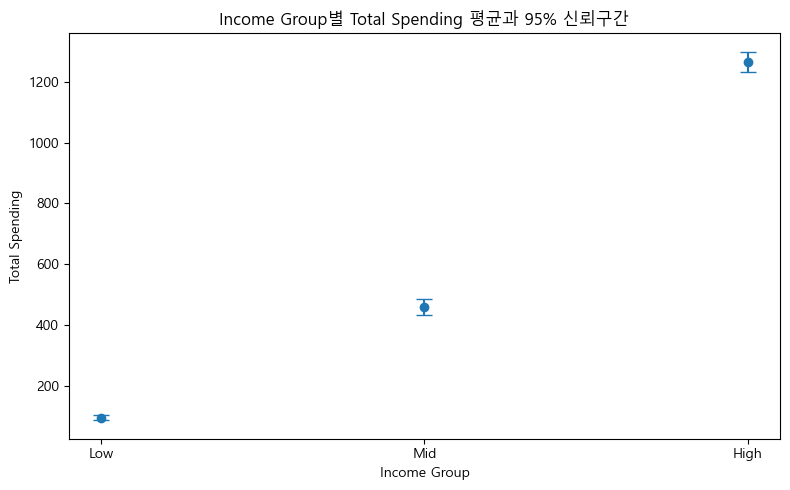

In [24]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프
groups = ['Low', 'Mid', 'High']

means = []
ci_lowers = []
ci_uppers = []

for g in groups:
    group_data = df[df['Income_Group'] == g]['Total_Spending']
    
    n_g = group_data.shape[0]
    mean_g = group_data.mean()
    std_g = group_data.std(ddof=1)
    se_g = std_g / np.sqrt(n_g)

    t_crit = stats.t.ppf(0.975, df=n_g-1)   # 95% CI
    lower = mean_g - t_crit * se_g
    upper = mean_g + t_crit * se_g

    means.append(mean_g)
    ci_lowers.append(mean_g - lower)
    ci_uppers.append(upper - mean_g)

    print(f"{g} 그룹 95% CI: [{lower:,.2f}, {upper:,.2f}]")
    
    plt.figure(figsize=(8, 5))

plt.errorbar(
    groups,
    means,
    yerr=[ci_lowers, ci_uppers],
    fmt='o',
    capsize=6
)

plt.xlabel("Income Group")
plt.ylabel("Total Spending")
plt.title("Income Group별 Total Spending 평균과 95% 신뢰구간")
plt.tight_layout()
plt.show()

### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [25]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
# 표본 크기
n1 = len(no_child)
n2 = len(yes_child)

# 평균
mean1 = no_child.mean()
mean2 = yes_child.mean()

# 표준편차 (표본)
std1 = no_child.std(ddof=1)
std2 = yes_child.std(ddof=1)

# Welch's t-test (등분산 가정 X)
t_stat, p_value = stats.ttest_ind(no_child, yes_child, equal_var=False)

# Cohen's d (Welch 버전: pooled SD 대신 평균 표준편차)
sd_pooled = np.sqrt((std1**2 + std2**2) / 2)
cohen_d = (mean1 - mean2) / sd_pooled

print("[Welch's t-test 결과]")
print(f"무자녀 평균 소비: {mean1:,.2f}")
print(f"유자녀 평균 소비: {mean2:,.2f}")
print(f"t 통계량 = {t_stat:.3f}")
print(f"p-value = {p_value:.4f}")

print("\n[Cohen's d 효과크기]")
print(f"Cohen's d = {cohen_d:.3f}")

# 효과크기 해석
abs_d = abs(cohen_d)
if abs_d < 0.5:
    effect = "작은 효과"
elif abs_d < 0.8:
    effect = "중간 효과"
else:
    effect = "큰 효과"

print(f"효과크기 해석: {effect}")

[Welch's t-test 결과]
무자녀 평균 소비: 1,104.86
유자녀 평균 소비: 407.25
t 통계량 = 24.989
p-value = 0.0000

[Cohen's d 효과크기]
Cohen's d = 1.255
효과크기 해석: 큰 효과


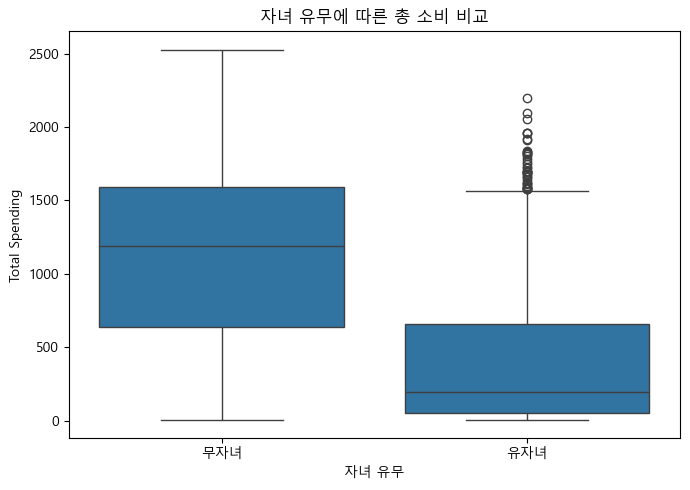

In [26]:
# TODO 3-2(c): 박스플롯 비교 시각화
plt.figure(figsize=(7, 5))

sns.boxplot(
    x='Has_Children',
    y='Total_Spending',
    data=df
)

plt.xticks([0, 1], ['무자녀', '유자녀'])
plt.xlabel("자녀 유무")
plt.ylabel("Total Spending")
plt.title("자녀 유무에 따른 총 소비 비교")
plt.tight_layout()
plt.show()

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [27]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
# 차이 계산 (Wine - Meat)
diff = wines - meat

# 대응표본
n = diff.shape[0]

# 차이의 평균과 표준편차
mean_diff = diff.mean()
std_diff = diff.std(ddof=1)

# 대응표본 t-검정 (차이의 평균 = 0 검정)
t_stat, p_value = stats.ttest_1samp(diff, 0)

# Cohen's d (paired version)
cohen_d = mean_diff / std_diff

print("[대응표본 t-검정 결과]")
print(f"와인 평균 소비: {wines.mean():,.2f}")
print(f"육류 평균 소비: {meat.mean():,.2f}")
print(f"평균 차이 (Wine - Meat): {mean_diff:,.2f}")
print(f"t 통계량 = {t_stat:.3f}")
print(f"p-value = {p_value:.4f}")

print("\n[Cohen's d 효과크기]")
print(f"Cohen's d = {cohen_d:.3f}")

# 효과크기 해석
abs_d = abs(cohen_d)
if abs_d < 0.5:
    effect = "작은 효과"
elif abs_d < 0.8:
    effect = "중간 효과"
else:
    effect = "큰 효과"

print(f"효과크기 해석: {effect}")

[대응표본 t-검정 결과]
와인 평균 소비: 304.13
육류 평균 소비: 166.98
평균 차이 (Wine - Meat): 137.14
t 통계량 = 23.093
p-value = 0.0000

[Cohen's d 효과크기]
Cohen's d = 0.488
효과크기 해석: 작은 효과


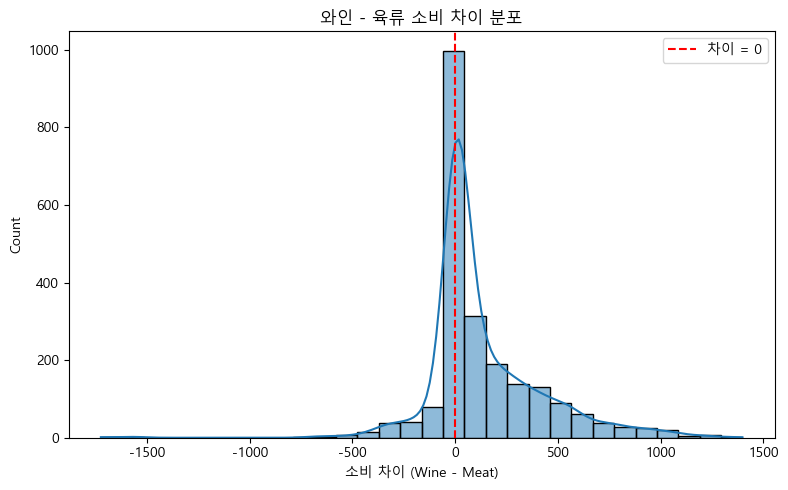

In [28]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프
plt.figure(figsize=(8, 5))

sns.histplot(diff, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--', label='차이 = 0')

plt.xlabel("소비 차이 (Wine - Meat)")
plt.ylabel("Count")
plt.title("와인 - 육류 소비 차이 분포")
plt.legend()
plt.tight_layout()
plt.show()

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [29]:
power_analysis = TTestIndPower()

# TODO 3-4(a): 문제 3-2 기준 검정력 계산
alpha = 0.05
effect_size = abs(cohen_d)          # 양측검정이므로 절대값 사용
ratio = n2 / n1                     # 집단 크기 비율

power = power_analysis.power(
    effect_size=effect_size,
    nobs1=n1,
    alpha=alpha,
    ratio=ratio,
    alternative='two-sided'
)

print("[3-4(a)] 문제 3-2 기준 검정력(Power)")
print(f"alpha = {alpha}")
print(f"effect size |d| = {effect_size:.3f}")
print(f"n1(무자녀) = {n1}, n2(유자녀) = {n2}, ratio(n2/n1) = {ratio:.3f}")
print(f"Power = {power:.4f}")

# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정
alpha = 0.05
target_power = 0.80
small_d = 0.2

# (기본) 1:1 동일 표본 수 가정
n_required = power_analysis.solve_power(
    effect_size=small_d,
    power=target_power,
    alpha=alpha,
    ratio=1.0,
    alternative='two-sided'
)

# 표본수는 정수여야 하므로 올림 처리(외부 라이브러리 없이)
n_required_int = int(np.ceil(n_required))

print("\n[3-4(b)] 작은 효과(d=0.2) 탐지에 필요한 표본 크기")
print(f"alpha = {alpha}, target power = {target_power}, effect size d = {small_d}")
print(f"필요 표본수(각 집단) ≈ {n_required:.2f} → {n_required_int}명 (올림)")
print(f"총 표본수(1:1 가정) ≈ {2*n_required_int}명")

[3-4(a)] 문제 3-2 기준 검정력(Power)
alpha = 0.05
effect size |d| = 0.488
n1(무자녀) = 637, n2(유자녀) = 1599, ratio(n2/n1) = 2.510
Power = 1.0000

[3-4(b)] 작은 효과(d=0.2) 탐지에 필요한 표본 크기
alpha = 0.05, target power = 0.8, effect size d = 0.2
필요 표본수(각 집단) ≈ 393.41 → 394명 (올림)
총 표본수(1:1 가정) ≈ 788명


---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [31]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)
group_data_list = []  # Levene/QQ plot에서도 재사용하려고 모아둠

for g in edu_groups:
    grp = df[df['Education_Group'] == g]['Total_Spending'].dropna()
    group_data_list.append(grp)

    n = grp.shape[0]
    # Shapiro-Wilk (표본 크기가 너무 크면 민감해질 수 있음)
    W, p = stats.shapiro(grp)

    clt_ok = (n >= 30)

    print(f"{g:>13} | n={n:4d} | W={W:.4f} | p-value={p:.4f} | CLT(n>=30)={clt_ok}")

# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
use_welch = None

stat_levene, p_levene = stats.levene(*group_data_list, center='median')

print(f"Levene stat = {stat_levene:.4f}, p-value = {p_levene:.4f}")
print(f"등분산 가정 {'위반' if use_welch else '충족'} → use_welch = {use_welch}")

Undergraduate | n= 255 | W=0.7605 | p-value=0.0000 | CLT(n>=30)=True
     Graduate | n=1126 | W=0.8743 | p-value=0.0000 | CLT(n>=30)=True
 Postgraduate | n= 855 | W=0.8765 | p-value=0.0000 | CLT(n>=30)=True
Levene stat = 13.2893, p-value = 0.0000
등분산 가정 충족 → use_welch = None


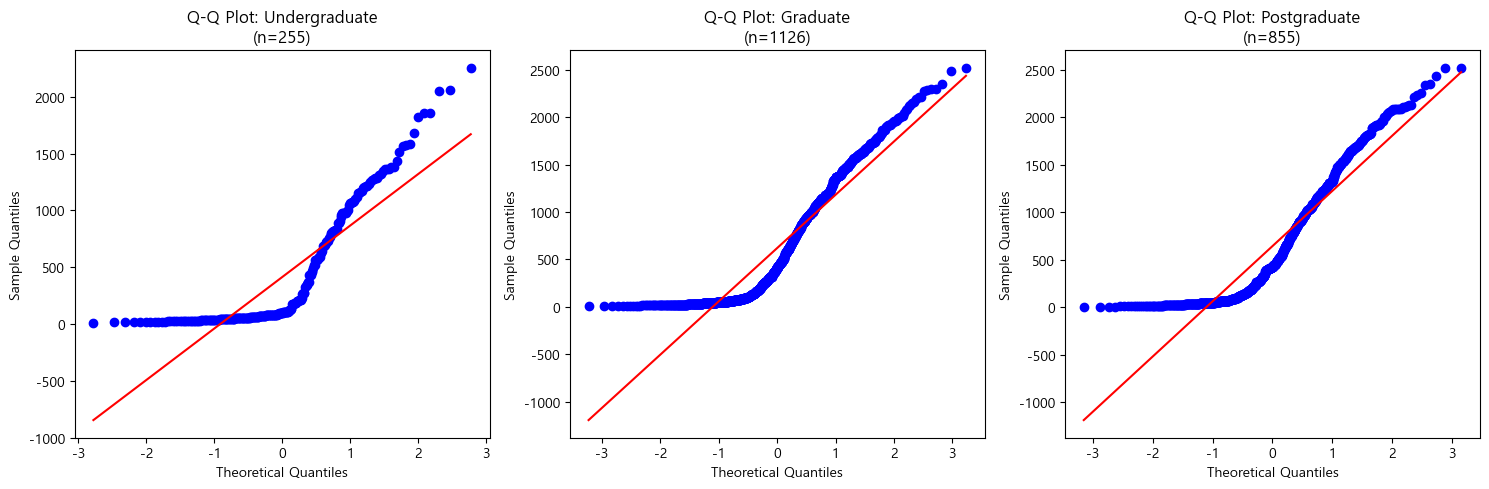

In [32]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, g, grp in zip(axes, edu_groups, group_data_list):
    # Q-Q Plot
    stats.probplot(grp, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot: {g}\n(n={len(grp)})")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [33]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
groups = [group_data[g] for g in edu_groups]
k = len(groups)
n_total = sum(len(g) for g in groups)

print("\n[4-2(a)] 분산분석 결과")
print("-" * 60)

# (1) 정규 ANOVA or Welch ANOVA
if not use_welch:
    # One-way ANOVA
    F_stat, p_anova = stats.f_oneway(*groups)
    print(f"One-way ANOVA: F = {F_stat:.4f}, p-value = {p_anova:.4f}")
else:
    # Welch's ANOVA (pingouin)
    welch_res = pg.welch_anova(
        dv='Total_Spending',
        between='Education_Group',
        data=df
    )
    F_stat = welch_res['F'].iloc[0]
    p_anova = welch_res['p-unc'].iloc[0]
    print(f"Welch's ANOVA: F = {F_stat:.4f}, p-value = {p_anova:.4f}")
    
# (2) Kruskal-Wallis (비모수)
H_stat, p_kw = stats.kruskal(*groups)
print(f"Kruskal-Wallis: H = {H_stat:.4f}, p-value = {p_kw:.4f}")


# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)
# 전체 평균
grand_mean = np.mean(np.concatenate(groups))

# 제곱합 계산
SS_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in groups)
SS_within = sum(((g - np.mean(g))**2).sum() for g in groups)
SS_total = SS_between + SS_within

df_between = k - 1
df_within = n_total - k

MS_within = SS_within / df_within

eta_sq = SS_between / SS_total
omega_sq = (SS_between - df_between * MS_within) / (SS_total + MS_within)

print("\n[효과 크기]")
print(f"η² = {eta_sq:.4f}")
print(f"ω² = {omega_sq:.4f}")


[4-2(a)] 분산분석 결과
------------------------------------------------------------
One-way ANOVA: F = 15.5088, p-value = 0.0000
Kruskal-Wallis: H = 36.6133, p-value = 0.0000

[효과 크기]
η² = 0.0137
ω² = 0.0128


In [36]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g
if not use_welch:
    print("\n[Tukey HSD 사후검정]")
    tukey = pairwise_tukeyhsd(
        endog=df['Total_Spending'],
        groups=df['Education_Group'],
        alpha=0.05
    )
    print(tukey)

    print("\n[쌍별 Cohen's d]")
    for i in range(len(edu_groups)):
        for j in range(i+1, len(edu_groups)):
            g1, g2 = edu_groups[i], edu_groups[j]
            x1, x2 = group_data[g1], group_data[g2]

            m1, m2 = x1.mean(), x2.mean()
            s1, s2 = x1.std(ddof=1), x2.std(ddof=1)

            sd_pooled = np.sqrt((s1**2 + s2**2) / 2)
            d = (m1 - m2) / sd_pooled

            print(f"{g1} vs {g2}: d = {d:.3f}")
            
        else:
            print("\n[Games-Howell 사후검정]")
    gh = pg.pairwise_gameshowell(
        dv='Total_Spending',
        between='Education_Group',
        data=df
    )
    print(gh[['A', 'B', 'pval', 'hedges']])


[Tukey HSD 사후검정]
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
   group1        group2     meandiff p-adj    lower     upper   reject
----------------------------------------------------------------------
    Graduate  Postgraduate   24.3975 0.6407  -39.2206   88.0156  False
    Graduate Undergraduate -208.1394    0.0 -305.4025 -110.8763   True
Postgraduate Undergraduate -232.5369    0.0 -332.6057 -132.4681   True
----------------------------------------------------------------------

[쌍별 Cohen's d]
Undergraduate vs Graduate: d = -0.373
Undergraduate vs Postgraduate: d = -0.409

[Games-Howell 사후검정]
Graduate vs Postgraduate: d = -0.040

[Games-Howell 사후검정]

[Games-Howell 사후검정]
              A              B          pval    hedges
0      Graduate   Postgraduate  6.523632e-01 -0.040121
1      Graduate  Undergraduate  8.920656e-08  0.355688
2  Postgraduate  Undergraduate  9.577128e-09  0.389636


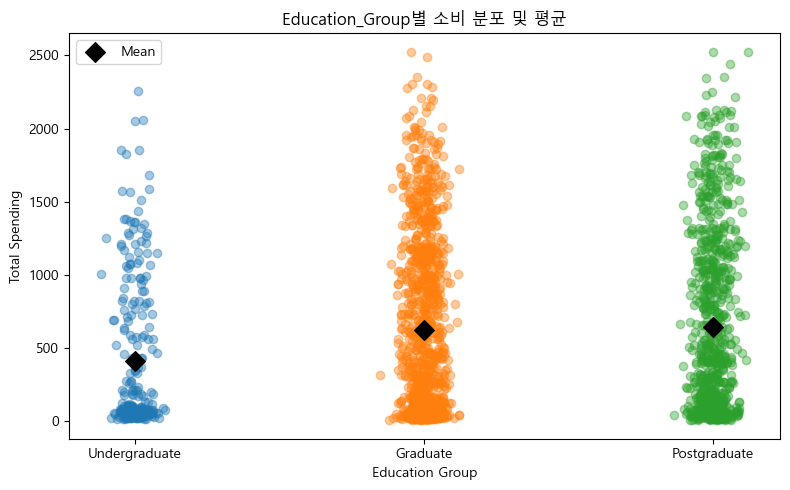

In [37]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드
plt.figure(figsize=(8, 5))

# 개별 데이터 (jitter)
for i, g in enumerate(edu_groups):
    y = group_data[g]
    x = np.random.normal(i, 0.04, size=len(y))
    plt.scatter(x, y, alpha=0.4)

# 평균 (다이아몬드)
means = [np.mean(group_data[g]) for g in edu_groups]
plt.scatter(range(len(edu_groups)), means, marker='D', s=100, color='black', label='Mean')

plt.xticks(range(len(edu_groups)), edu_groups)
plt.xlabel("Education Group")
plt.ylabel("Total Spending")
plt.title("Education_Group별 소비 분포 및 평균")
plt.legend()
plt.tight_layout()
plt.show()

### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [38]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
# 관측도수
obs = crosstab_no_margin.values

# 카이제곱 검정
chi2, p_value, dof, expected = stats.chi2_contingency(obs, correction=False)

n = obs.sum()

print("[4-3(a)] 카이제곱 독립성 검정")
print("-" * 60)
print(f"χ² = {chi2:.4f}, dof = {dof}, p-value = {p_value:.4f}")

# Cochran 규칙 확인
expected_lt5 = (expected < 5).sum()
total_cells = expected.size
ratio_lt5 = expected_lt5 / total_cells

print(f"기대빈도 < 5 셀 비율: {ratio_lt5*100:.2f}%")

if ratio_lt5 > 0.20:
    print("⚠️ Cochran 규칙 위반 → Fisher 정확검정 고려 필요")
else:
    print("Cochran 규칙 충족 → 카이제곱 검정 사용 가능")
    
# TODO 4-3(b): φ (phi) 계산
phi = np.sqrt(chi2 / n)

print("\n[4-3(b)] 효과크기 φ")
print(f"φ = {phi:.3f}")

# 해석
if phi < 0.1:
    effect = "매우 작은 효과"
elif phi < 0.3:
    effect = "작은 효과"
elif phi < 0.5:
    effect = "중간 효과"
else:
    effect = "큰 효과"

print(f"효과크기 해석: {effect}")

# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산
a = obs[0, 1]  # Single & Response=True
b = obs[0, 0]  # Single & Response=False
c = obs[1, 1]  # Together & Response=True
d = obs[1, 0]  # Together & Response=False

# Odds Ratio
OR = (a * d) / (b * c)

# 표준오차(SE)
SE = np.sqrt(1/a + 1/b + 1/c + 1/d)

# 95% CI
log_or = np.log(OR)
ci_lower = np.exp(log_or - 1.96 * SE)
ci_upper = np.exp(log_or + 1.96 * SE)

print("\n[4-3(c)] 오즈비(Odds Ratio)")
print(f"OR = {OR:.3f}")
print(f"95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]")

[4-3(a)] 카이제곱 독립성 검정
------------------------------------------------------------
χ² = 9.5411, dof = 1, p-value = 0.0020
기대빈도 < 5 셀 비율: 0.00%
Cochran 규칙 충족 → 카이제곱 검정 사용 가능

[4-3(b)] 효과크기 φ
φ = 0.065
효과크기 해석: 매우 작은 효과

[4-3(c)] 오즈비(Odds Ratio)
OR = 1.352
95% CI = [1.116, 1.638]


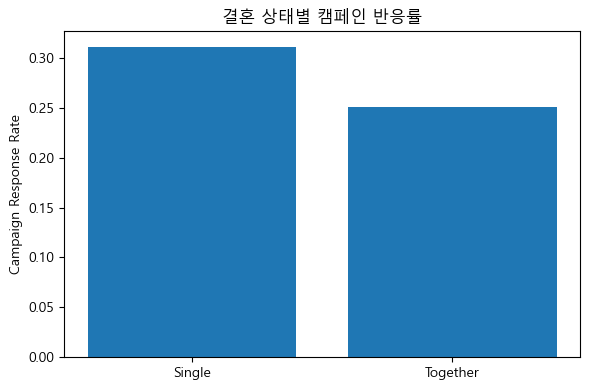

In [39]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵
response_rate = (
    df.groupby('Marital_Group')['Campaign_Response']
      .mean()
)

plt.figure(figsize=(6, 4))
plt.bar(response_rate.index, response_rate.values)

plt.ylabel("Campaign Response Rate")
plt.title("결혼 상태별 캠페인 반응률")
plt.tight_layout()
plt.show()

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [40]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
total = observed.sum()
expected = np.array([total/3, total/3, total/3])

chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)
dof = len(observed) - 1

print("[4-4(a)] 카이제곱 적합도 검정 (균등 분포 가정)")
print("-" * 60)
print(f"관측도수: {dict(zip(channel_names, observed))}")
print(f"기대도수(균등): {dict(zip(channel_names, expected.round(2)))}")
print(f"χ² = {chi2_stat:.4f}, dof = {dof}, p-value = {p_value:.4f}")

# TODO 4-4(b): Cohen's w 계산
p_obs = observed / total
p_exp = np.array([1/3, 1/3, 1/3])

w = np.sqrt(np.sum((p_obs - p_exp)**2 / p_exp))

print("\n[4-4(b)] 효과크기 Cohen's w")
print(f"w = {w:.4f}")

[4-4(a)] 카이제곱 적합도 검정 (균등 분포 가정)
------------------------------------------------------------
관측도수: {'Web': np.int64(9140), 'Catalog': np.int64(5955), 'Store': np.int64(12959)}
기대도수(균등): {'Web': np.float64(9351.33), 'Catalog': np.float64(9351.33), 'Store': np.float64(9351.33)}
χ² = 2630.1063, dof = 2, p-value = 0.0000

[4-4(b)] 효과크기 Cohen's w
w = 0.3062


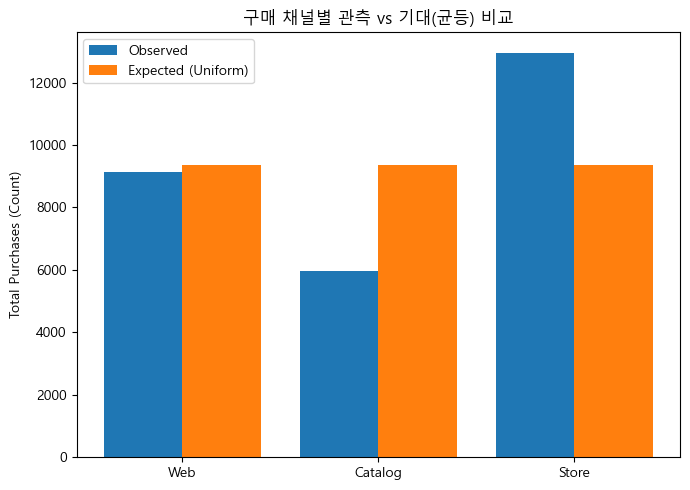

In [41]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프
x = np.arange(len(channel_names))
bar_width = 0.4

plt.figure(figsize=(7, 5))

plt.bar(x - bar_width/2, observed, width=bar_width, label='Observed')
plt.bar(x + bar_width/2, expected, width=bar_width, label='Expected (Uniform)')

plt.xticks(x, channel_names)
plt.ylabel("Total Purchases (Count)")
plt.title("구매 채널별 관측 vs 기대(균등) 비교")
plt.legend()
plt.tight_layout()
plt.show()

---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [ ]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산
# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)

In [ ]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)

In [ ]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요

### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [ ]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b

# TODO 5-2(a): z-비율검정
# TODO 5-2(b): Cohen's h 효과 크기
# TODO 5-2(c): Wilson 신뢰구간

In [ ]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)

> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [ ]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산
# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)

---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [ ]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [ ]:
# TODO C-2: 비즈니스 제안서 작성

---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛